In [28]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,balanced_accuracy_score
import numpy as np

In [30]:
from tqdm import tqdm

### SLS Dataset Review

In [31]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\AppData\Local\Temp\ipykernel_628\701159028.py:1: DtypeWarning: Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")


In [32]:
sls.iddesa.unique().shape

(5957,)

In [33]:
idm = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/newdata_edit.csv")

In [34]:
sls_new = sls.set_index("iddesa").join(idm.set_index("bps_kelurahan_kode"), how ="left", rsuffix = "idm")

In [35]:
sls_new["iddesa"] = sls_new.index
sls_new["bps_kelurahan_kode"] = sls_new.index

In [36]:
sls_new.shape

(222861, 97)

In [37]:
sls_new = sls_new.drop_duplicates(["idsls"])

In [38]:
sls_new.shape

(219919, 97)

#### Preprocessing

In [39]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general sls sentinel 10m ES RES/"
destpath = 'C:/Users/jwst2/Python/tesis/jpg/IDM/09. Desa Sentinel 10m ES RES'

In [40]:
os.chdir(destpath)
if os.path.isdir('MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')

In [41]:

for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        if(not sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].empty):
            if(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "MAJU"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "BERKEMBANG"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "TERTINGGAL"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "MANDIRI"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
       

1it [07:45, 465.63s/it]


In [42]:
test_path = 'C:/Users/jwst2/Python/tesis/jpg/IDM/test sls 10m es res/'

In [44]:
split = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/test_idm_res.csv")

In [45]:
split_test = split

In [46]:
os.chdir(test_path)
if os.path.isdir('MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')

In [47]:
catlist = ["MAJU MANDIRI","TERTINGGAL BERKEMBANG"]

In [48]:
destpath + catlist[0]

'C:/Users/jwst2/Python/tesis/jpg/IDM/09. Desa Sentinel 10m ES RESMAJU MANDIRI'

In [49]:
for i in range(0,2):
    print(catlist[i])
    yourpath = destpath +"/"+ catlist[i]
    for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
        for name in files:
            try :
                if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                    shutil.move(os.path.join(root, name), test_path+catlist[i]+"/"+name)
            except Exception:
                print(name)
                pass 

MAJU MANDIRI


1it [00:35, 35.88s/it]


TERTINGGAL BERKEMBANG


1it [00:44, 44.46s/it]


### Run Dataset

In [50]:
path = Path.cwd() / (destpath)

In [51]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('MAJU MANDIRI'),Path('TERTINGGAL BERKEMBANG')]

In [52]:
fname = (path/"MAJU MANDIRI").ls()[0]
fname

Path('MAJU MANDIRI/32010200010001.jpg')

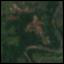

In [53]:
img = Image.open(fname)
img

In [54]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label,
                 item_tfms = Resize(64)) # data augmentation (mult multiplies the default transformation values)

In [55]:
dls = blocks.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


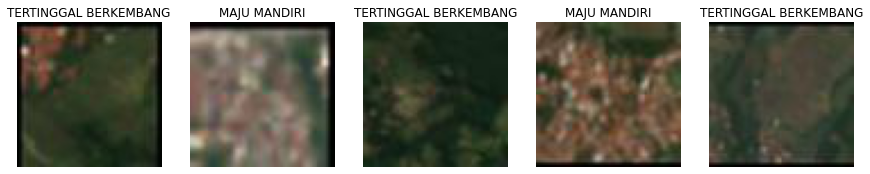

In [56]:
dls.show_batch(nrows=1, ncols=5)

In [57]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.00363078061491251)

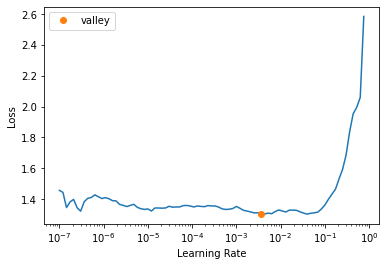

In [58]:
learn.lr_find()

In [59]:
learn.unfreeze()

In [60]:
learn.fit_one_cycle(7,lr_max = 7e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.797834,0.674187,0.603327,0.563043,0.610173,0.563043,0.530928,0.625852,15:39
1,0.721264,1.275333,0.556245,0.571980,0.574962,0.571980,0.554920,0.592656,10:26
2,0.663712,7.662222,0.613970,0.573684,0.629586,0.573684,0.542944,0.650621,10:26
3,0.635071,0.633608,0.653651,0.629545,0.654583,0.629545,0.626059,0.678577,10:22
4,0.624545,1.513632,0.656752,0.636380,0.654281,0.636380,0.635287,0.692593,10:30
5,0.624996,0.619463,0.662673,0.644003,0.659669,0.644003,0.643846,0.702426,10:24
6,0.618253,0.649021,0.662955,0.644719,0.659655,0.644719,0.644723,0.703729,10:24


In [61]:
dls.vocab

['MAJU MANDIRI', 'TERTINGGAL BERKEMBANG']

In [62]:
dls.train.items[1500]

Path('MAJU MANDIRI/32040400110075.jpg')

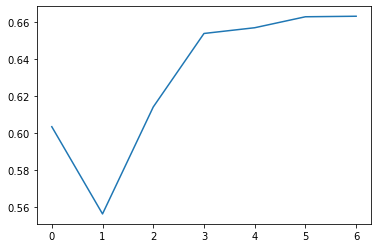

In [63]:
plt.plot(L(learn.recorder.values).itemgot(2));

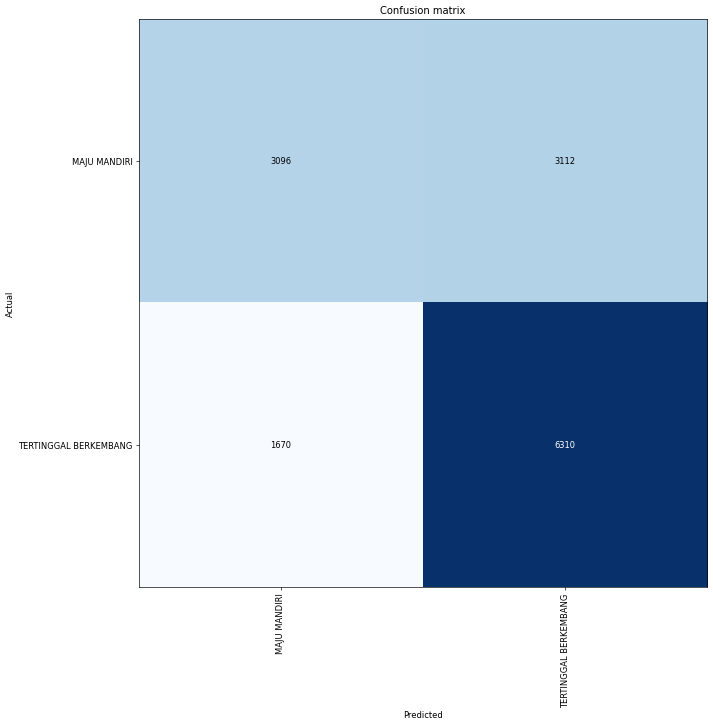

In [64]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.plot_top_losses(3, figsize=(20,11))

In [66]:
learn.export('C:/Users/jwst2/Python/tesis/models/SLS Densenet Sentinel ES RES.pkl')

### Up level

In [67]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if('TERTINGGAL BERKEMBANG' in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [68]:
preds,_ = learn.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [69]:
pd.value_counts(true_label)

1    71463
0    56233
dtype: int64

In [70]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,0.352340,0.647660,32071700030033,1.0,3207170003
1,0.642235,0.357765,32150700060030,0.0,3215070006
2,0.822234,0.177766,32042500030039,0.0,3204250003
3,0.310630,0.689370,32151400040005,1.0,3215140004
4,0.813970,0.186030,32091410050001,0.0,3209141005


In [71]:
pd.value_counts(df.stat)

1.0    85651
0.0    42045
Name: stat, dtype: int64

In [72]:
df["true_lab"] = true_label

In [73]:
pd.value_counts(df.true_lab)

1    71463
0    56233
Name: true_lab, dtype: int64

In [74]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.6630434782608695

In [75]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.352340,0.647660,32071700030033,1.0,3207170003,0
1,0.642235,0.357765,32150700060030,0.0,3215070006,0
2,0.822234,0.177766,32042500030039,0.0,3204250003,0
3,0.310630,0.689370,32151400040005,1.0,3215140004,1
4,0.813970,0.186030,32091410050001,0.0,3209141005,1


In [85]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [86]:
desa_pred.columns = ["pred","true"]

In [87]:
pd.value_counts(df.stat)

1.0    85651
0.0    42045
Name: stat, dtype: int64

In [88]:
for i in np.arange(0.0, 0.95, 0.025):
    value = round(i,3)
    desa_pred["label"+str(value)] = 0
    desa_pred.loc[desa_pred.pred >value,"label"+str(value)] = 1

In [89]:
desa_pred.head()

,pred,true,label0.0,label0.025,label0.05,label0.075,label0.1,label0.125,label0.15,label0.175,...,label0.7,label0.725,label0.75,label0.775,label0.8,label0.825,label0.85,label0.875,label0.9,label0.925
iddesa,,,,,,,,,,,,,,,,,,,,,
3201010001,0.964286,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010002,1.000000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010003,1.000000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010004,0.977273,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010005,0.962963,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [90]:
for j in range(2,40):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.0
accuracy : 0.6397501156871819
precision : 0.6388694230320019
result label0.025
accuracy : 0.6439148542341508
precision : 0.6418998354102986
result label0.05
accuracy : 0.6510874595094863
precision : 0.6473108043788672
result label0.075
accuracy : 0.6568718186024989
precision : 0.6517664023071377
result label0.1
accuracy : 0.6640444238778344
precision : 0.6572678658240155
result label0.125
accuracy : 0.6679777880610829
precision : 0.6607799852832965
result label0.15
accuracy : 0.6719111522443313
precision : 0.6645193260654113
result label0.175
accuracy : 0.6763072651550208
precision : 0.668501376032024
result label0.2
accuracy : 0.6788523831559463
precision : 0.6713780918727915
result label0.225
accuracy : 0.6834798704303563
precision : 0.6756756756756757
result label0.25
accuracy : 0.6846367422489588
precision : 0.677992277992278
result label0.275
accuracy : 0.6855622397038408
precision : 0.6800830952999221
result label0.3
accuracy : 0.6862563627950024
precision : 0.682

In [91]:
pd.value_counts(desa_pred.true)

1.0    2746
0.0    1576
Name: true, dtype: int64

### Test result

In [92]:
path_pred = Path.cwd() / (test_path)
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [93]:
len(test_files)

16516

In [94]:
test_dl = learn.dls.test_dl(test_files)

In [95]:
preds,_ = learn.get_preds(dl  =test_dl)

In [96]:
str(test_files[1])[-18:-4]

'32010200180002'

In [97]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("TERTINGGAL BERKEMBANG" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [98]:
test = pd.DataFrame(preds)

In [99]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [100]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [101]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.790847,0.209153,32010200180001,0,3201020018,0.0
1,0.777656,0.222344,32010200180002,0,3201020018,0.0
2,0.771218,0.228782,32010200180003,0,3201020018,0.0
3,0.635942,0.364058,32010200180004,0,3201020018,0.0
4,0.634194,0.365806,32010200180005,0,3201020018,0.0


In [102]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [103]:
desa_pred_test

,stat,true_lab
,mean,mean
iddesa,,
3201010008,1.000000,1.0
3201020018,0.295455,0.0
3201030001,1.000000,1.0
3201030002,0.891304,0.0
3201040001,0.930233,0.0
...,...,...
3217150012,0.941176,0.0
3218040012,1.000000,1.0


In [104]:
desa_pred_test.columns = ["pred","true"]

In [142]:
desa_pred_test["pred_lab"] = 0
desa_pred_test.loc[desa_pred_test.pred > 0.475,"pred_lab"] = 1

In [143]:
desa_pred_test

,pred,true,pred_lab
iddesa,,,
3201010008,1.000000,1.0,1
3201020018,0.295455,0.0,0
3201030001,1.000000,1.0,1
3201030002,0.891304,0.0,1
3201040001,0.930233,0.0,1
...,...,...,...
3217150012,0.941176,0.0,1
3218040012,1.000000,1.0,1
3218100005,1.000000,1.0,1


In [144]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.73125
balanced_accuracy_score : 0.6640184809556007
precision : 0.7335092348284961
recall : 0.9084967320261438
f1 : 0.8116788321167884
rocauc : 0.6640184809556007
